In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

читаем файл

In [83]:
url = 'https://raw.githubusercontent.com/sddanait12/data-analysis-project/refs/heads/main/heart.csv'
data = pd.read_csv(url)
print(data.head())

   Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR  \
0   40   M           ATA        140          289          0     Normal    172   
1   49   F           NAP        160          180          0     Normal    156   
2   37   M           ATA        130          283          0         ST     98   
3   48   F           ASY        138          214          0     Normal    108   
4   54   M           NAP        150          195          0     Normal    122   

  ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
0              N      0.0       Up             0  
1              N      1.0     Flat             1  
2              N      0.0       Up             0  
3              Y      1.5     Flat             1  
4              N      0.0       Up             0  


удалим дубликаты

In [84]:
data = data.drop_duplicates()

проверка на пропуски

In [85]:
print(data.isnull().sum())

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64


Проверим числовые столбцы на нереалистичные значения:

для начала проверим уровень холестерина

In [86]:
zero_cholesterol = data[data['Cholesterol'] == 0]
print(zero_cholesterol[['Cholesterol']])

     Cholesterol
293            0
294            0
295            0
296            0
297            0
..           ...
514            0
515            0
518            0
535            0
536            0

[172 rows x 1 columns]


Заменим нулевые значения медианой

In [87]:
median_chol = data['Cholesterol'].median()
data['Cholesterol'] = data['Cholesterol'].replace(0, median_chol)

проверка строк с нулевым давлением

In [88]:
abnormal_bp = data[(data['RestingBP'] <= 0) | (data['RestingBP'] > 250)]
print(abnormal_bp[['RestingBP']])

     RestingBP
449          0


так как всего лишь одна аномальная строчка, то удалим эту строку

In [89]:
data = data[data['RestingBP'] > 0]

проверим пульс

In [90]:
abnormal_hr = data[(data['MaxHR'] < 0) | (data['MaxHR'] > 250)]
print(abnormal_hr[['MaxHR']])

Empty DataFrame
Columns: [MaxHR]
Index: []


таких строчек нет

## Создание новых признаков

1. Возрастная группа (AgeGroup)
Так как возраст — важный фактор риска сердечных заболеваний.

In [91]:
data['AgeGroup'] = pd.cut(data['Age'],  bins=[20, 40, 60, 100],  labels=['Young', 'Adult', 'Elderly'])

2. Индекс нагрузки на сердце (HeartStressIndex)
Совместим максимальный пульс и депрессию ST для оценки степени ишемической нагрузки. MaxHR показывает, как сердце реагирует на физическую нагрузку. Высокий пульс может указывать на стрессовую реакцию сердца. Oldpeak отражает ишемические изменения в сердце при нагрузке.

In [92]:
data['HeartStressIndex'] = (data['MaxHR'] * data['Oldpeak']) / 100

3. Комбинированный риск гипертонии и холестерина (HyperCholRisk). Пациенты с высоким давлением и холестерином имеют повышенный риск сердечных заболеваний.

In [93]:
data['HyperCholRisk'] = np.where((data['RestingBP'] > 140) & (data['Cholesterol'] > 200), 1, 0)

4. Отклонение пульса от возрастной нормы (HRDeviation).
 Максимальный пульс в норме рассчитывается как $HRDeviation = MaxHR - (220 - Age) $
Отклонение от нормы может указывать на патологию.

In [94]:
data['HRDeviation'] = data['MaxHR'] - (220 - data['Age'])

5. Признак критической ишемии (CriticalIschemia)
Cильная депрессии ST (Oldpeak > 2) и нисходящий наклон ST (ST_Slope = Down).

In [95]:
data['CriticalIschemia'] = np.where((data['Oldpeak'] > 2) & (data['ST_Slope'] == 'Down'), 1, 0)

##Визуализация

1. Распределение целевой переменной (HeartDisease)
python


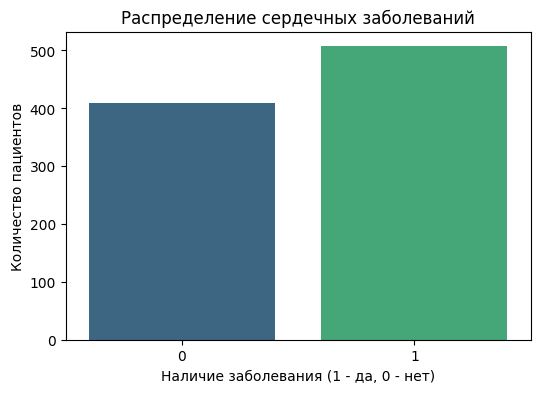

In [96]:
plt.figure(figsize=(6, 4))
sns.countplot(x='HeartDisease', data=data, hue='HeartDisease', palette='viridis', legend=False)
plt.title('Распределение сердечных заболеваний')
plt.xlabel('Наличие заболевания (1 - да, 0 - нет)')
plt.ylabel('Количество пациентов')
plt.show()

2. Распределение возраста

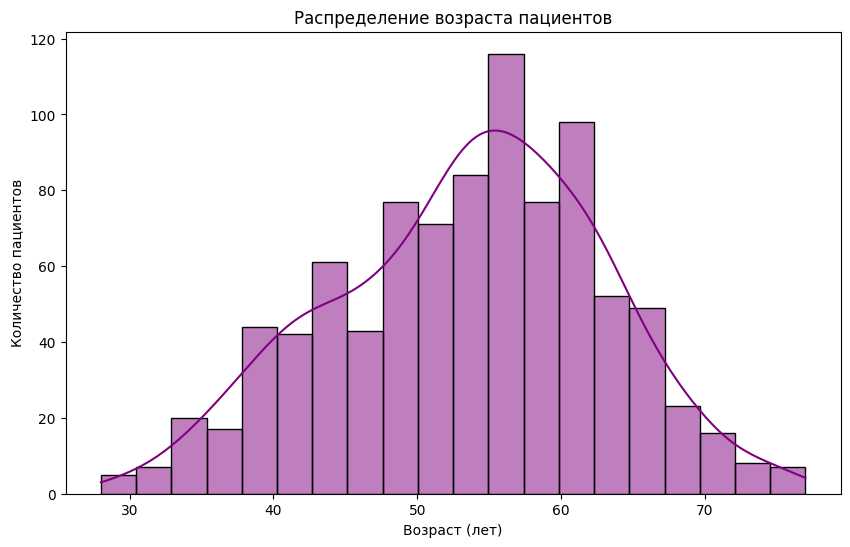

In [97]:
plt.figure(figsize=(10, 6))
sns.histplot(data['Age'], bins=20, kde=True, color='purple')
plt.title('Распределение возраста пациентов')
plt.xlabel('Возраст (лет)')
plt.ylabel('Количество пациентов')
plt.show()

3. Взаимосвязь возраста и холестерина

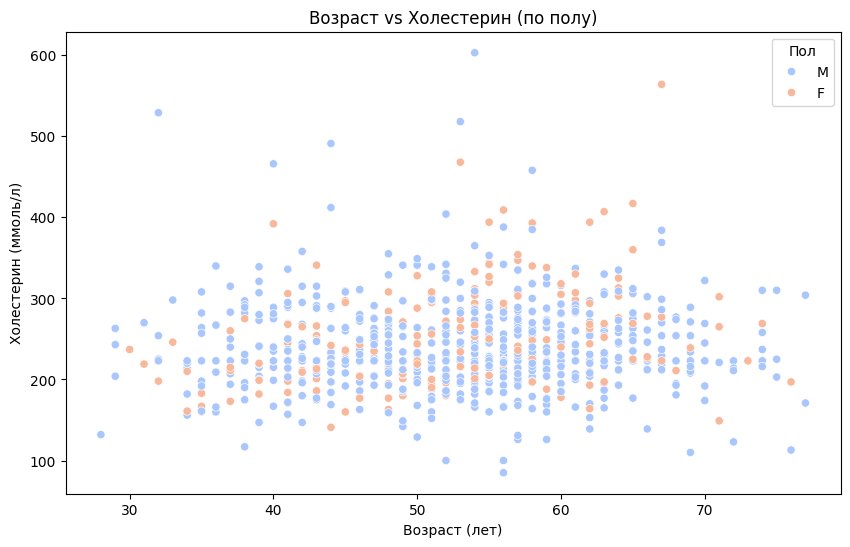

In [98]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Age', y='Cholesterol', hue='Sex', data=data, palette='coolwarm')
plt.title('Возраст vs Холестерин (по полу)')
plt.xlabel('Возраст (лет)')
plt.ylabel('Холестерин (ммоль/л)')
plt.legend(title='Пол')
plt.show()

4. Распределение типов боли в груди

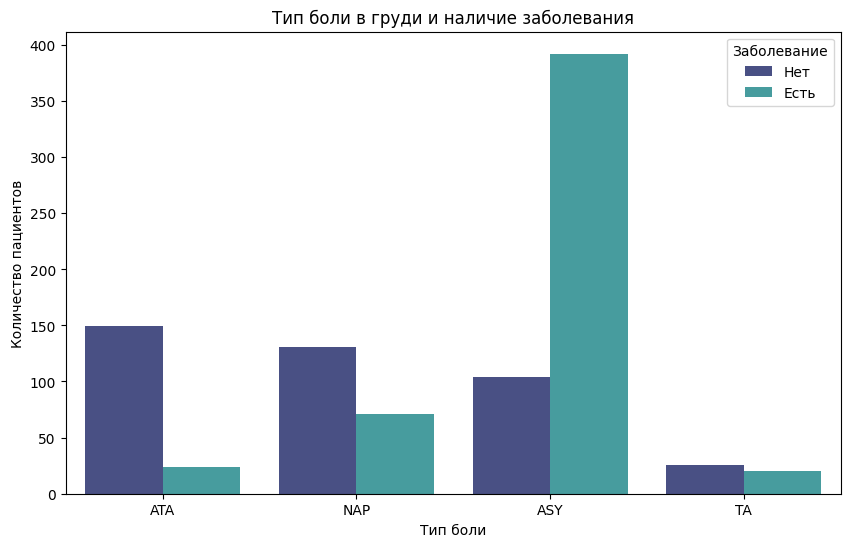

In [99]:
plt.figure(figsize=(10, 6))
sns.countplot(x='ChestPainType', hue='HeartDisease', data=data, palette='mako')
plt.title('Тип боли в груди и наличие заболевания')
plt.xlabel('Тип боли')
plt.ylabel('Количество пациентов')
plt.legend(title='Заболевание', labels=['Нет', 'Есть'])
plt.show()

5. Корреляция числовых признаков

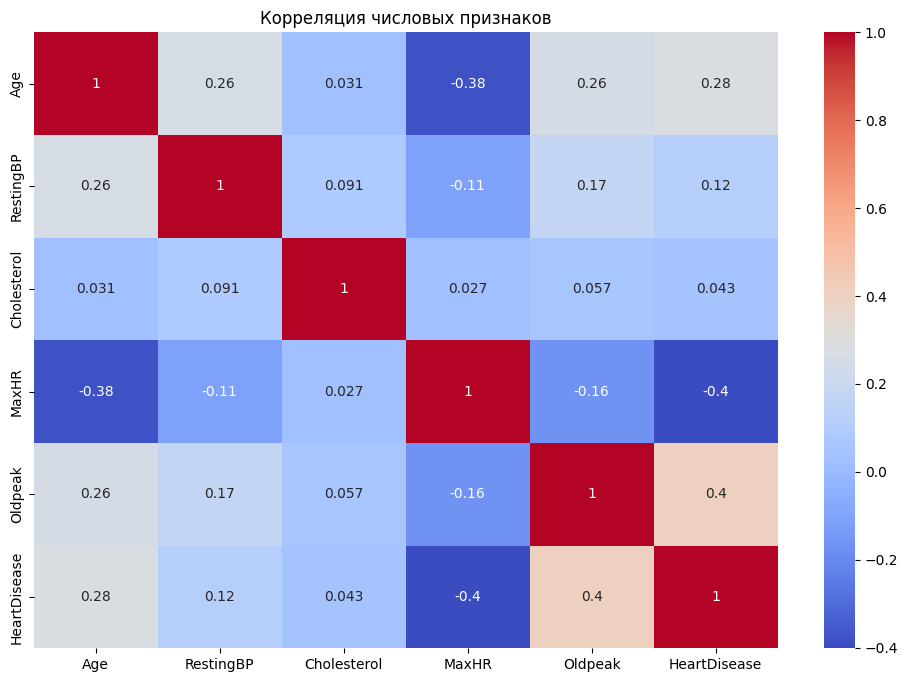

In [100]:

plt.figure(figsize=(12, 8))
corr_matrix = data[['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak', 'HeartDisease']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Корреляция числовых признаков')
plt.show()

6. Распределение пульса

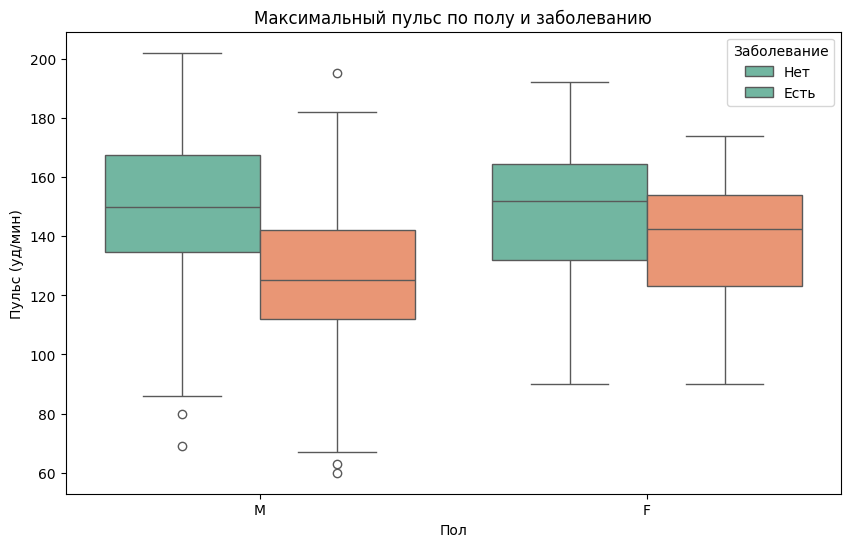

In [101]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Sex', y='MaxHR', hue='HeartDisease', data=data, palette='Set2')
plt.title('Максимальный пульс по полу и заболеванию')
plt.xlabel('Пол')
plt.ylabel('Пульс (уд/мин)')
plt.legend(title='Заболевание', labels=['Нет', 'Есть'])
plt.show()